# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## 5. Import the necessary packages

In [6]:
import time
import gym
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

#from ddpg_multi_agent import DdpgMultiAgent
from ddpg_agent import Agent

## 6. Instantiate the Agent

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=42)

## 7. Train the Agent with DDPG

In [8]:
def ddpg(n_episodes=1000, max_t=2000, print_every=50, target_score=0.5, learn_period=5, num_samples=10):
    all_scores_deque = deque(maxlen=print_every)
    all_scores = []
    scores_avg = []
    solved_flag = True # to print only the first time that the target score is achieved
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            actions = agent.act(states)                        # select an action (for each agent)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            #agent.step(states, actions, rewards, next_states, dones)            
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)            
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if t % learn_period == 0:
                for sample in range(num_samples):
                    agent.start_learn()
                    
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step

            if np.any(dones):
                break 
        all_scores_deque.append(np.mean(scores))
        all_scores.append(np.mean(scores))
        scores_avg.append(np.mean(all_scores_deque))
        duration = time.time() - start_time
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(all_scores_deque)), end="")

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tEpisode Duration: {:.2f}'.format(i_episode, np.mean(all_scores_deque), duration))
        if np.mean(all_scores_deque) >= target_score:
            if solved_flag==True:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(all_scores_deque)))
                solved_flag = False
                max_score = np.mean(all_scores_deque)
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            if np.mean(all_scores_deque) > max_score:
                max_score = np.mean(all_scores_deque)
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    return all_scores, scores_avg

In [9]:
scores, scores_avg = ddpg()

Episode 14	Average Score: 0.00

/home/workspace/ddpg_agent.py:102: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)


Episode 50	Average Score: -0.01	Episode Duration: 0.59
Episode 100	Average Score: 0.01	Episode Duration: 0.60
Episode 150	Average Score: 0.07	Episode Duration: 1.41
Episode 200	Average Score: 0.47	Episode Duration: 0.61
Episode 204	Average Score: 0.51
Environment solved in 204 episodes!	Average Score: 0.51
Episode 250	Average Score: 0.79	Episode Duration: 3.04
Episode 300	Average Score: 1.00	Episode Duration: 10.46
Episode 350	Average Score: 1.15	Episode Duration: 11.44
Episode 400	Average Score: 1.14	Episode Duration: 28.38
Episode 450	Average Score: 0.91	Episode Duration: 5.75
Episode 500	Average Score: 0.85	Episode Duration: 16.50
Episode 550	Average Score: 0.78	Episode Duration: 0.67
Episode 600	Average Score: 1.21	Episode Duration: 26.65
Episode 650	Average Score: 0.97	Episode Duration: 22.30
Episode 700	Average Score: 1.16	Episode Duration: 15.62
Episode 750	Average Score: 1.10	Episode Duration: 0.66
Episode 800	Average Score: 0.71	Episode Duration: 5.62
Episode 850	Average Score

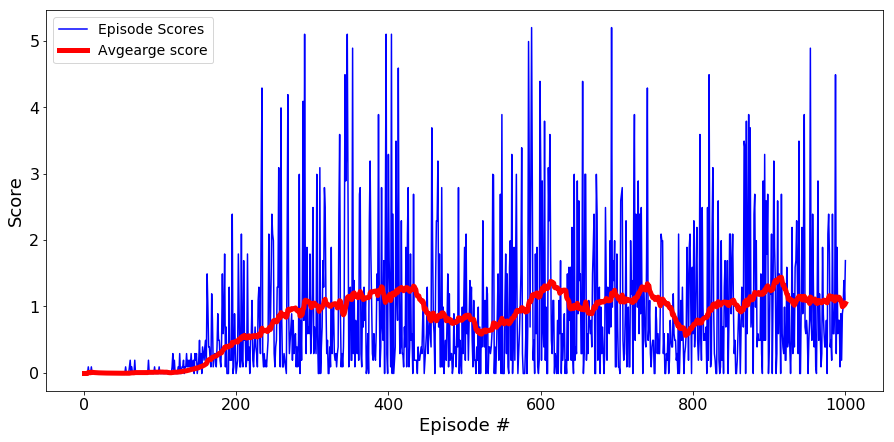

In [10]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,'b',label='Episode Scores')
plt.plot(np.arange(1, len(scores)+1), scores_avg,'r',\
         linewidth=5,label='Avgearge score')
plt.ylabel('Score', fontsize=18)
plt.xlabel('Episode #', fontsize=18)
ax.legend(fontsize=14)
plt.show()

When finished, you can close the environment.

In [11]:
env.close()